In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import sys, os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

In [2]:
path = '/content/drive/My Drive/Colab Notebooks/icml_face_data.csv'
data = pd.read_csv(path)

In [3]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [4]:
data.shape

(35887, 3)

In [5]:
data.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [6]:
data.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [7]:
data.columns

Index(['emotion', ' Usage', ' pixels'], dtype='object')

In [8]:
width, height = 48, 48
datapoints = data[' pixels'].tolist()

X = []
for xseq in datapoints:
    xx = [int(xp) for xp in xseq.split(' ')]
    xx = np.asarray(xx).reshape(width, height)
    X.append(xx.astype('float32'))

X = np.asarray(X)
X = np.expand_dims(X, -1)

#getting labels for training
y = pd.get_dummies(data['emotion']).to_numpy()

#storing them using numpy
#np.save('fdataX', X)
#np.save('flabels', y)

#print("Preprocessing Done")
#print("Number of Features: "+str(len(X[0])))
#print("Number of Labels: "+ str(len(y[0])))
#print("Number of examples in dataset:"+str(len(X)))
#print("X,y stored in fdataX.npy and flabels.npy respectively")

In [9]:
print ("number of examples = " + str(X.shape[0]))
print ("X shape: " + str(X.shape))
print ("Y shape: " + str(y.shape))

number of examples = 35887
X shape: (35887, 48, 48, 1)
Y shape: (35887, 7)


In [10]:
data[' Usage'].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name:  Usage, dtype: int64

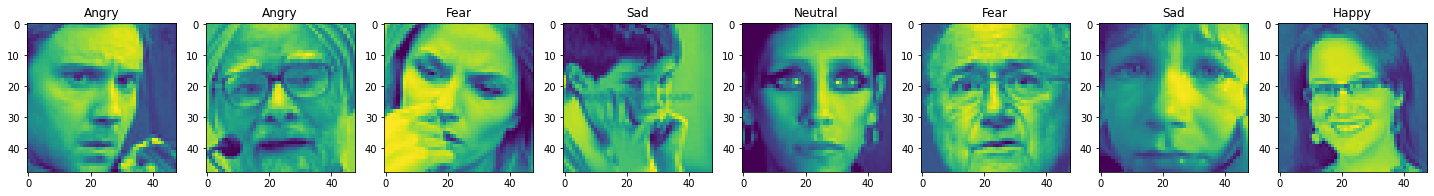

In [11]:
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
classes=np.array(emotion_labels)

h, w = 10, 10        
nrows, ncols = 1, 8  # array of sub-plots
figsize = [20, 30]     # figure size, inches

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

for i, axi in enumerate(ax.flat):
    img = np.mat(data[' pixels'][i]).reshape(height, width) 
    axi.imshow(img)

    # get indices of row/column
    rowid = i // ncols
    colid = i % ncols
    axi.set_title(emotion_labels[data.emotion[i]])

plt.tight_layout(True)
plt.show()



In [12]:
num_features = 64

# number of possible label values
num_labels = 7

batch_size = 64
epochs = 100
width, height = 48, 48

# Compute the arithmetic mean along the specified axis.
X -= np.mean(X, axis=0)

# Compute the standard deviation along the specified axis.
X /= np.std(X, axis=0)

In [13]:
#splitting into training, validation and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [14]:
print ("number of training examples = " + str(X_train.shape[0]))
#print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("y_test shape: " + str(y_test.shape))
print ("X_valid shape: " + str(X_valid.shape))
print ("y_valid shape: " + str(y_valid.shape))

number of training examples = 29068
X_train shape: (29068, 48, 48, 1)
y_train shape: (29068, 7)
X_test shape: (3589, 48, 48, 1)
y_test shape: (3589, 7)
X_valid shape: (3230, 48, 48, 1)
y_valid shape: (3230, 7)


In [15]:
# model architechture

# Initialising the CNN
model = Sequential()

'''
INPUT => [CONV => RELU => CONV => RELU => BN => POOL => DO] * 3 => [FC => RELU => DO] * 3 => FC

alexNet
INPUT => [CONV => RELU => POOL] * 2 => [CONV => RELU] * 3 => POOL => [FC => RELU => DO] * 2 => SOFTMAX
'''
# 1st Convolution layer
# Regularizer to apply a penalty on the layer's kernel
# staking conv2d make their features more expressive, to express more powerful features of the input, and with fewer parameters. As a practical disadvantage, we might need more memory to hold.(backpropagation)(https://cs231n.github.io/convolutional-networks/)
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same')) #(2 conv) has more flexibility in expressing non-linear transformations without loosing information.
model.add(BatchNormalization()) # scale (0,1)
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2))) # Maxpool removes information from the signal, dropout forces distributed representation. Reduce dimension size.
model.add(Dropout(0.5)) #64 neurons + 0.5 dropout means that you effectively have at most 32 neurons active. Prevent overfitting.

# 2nd Convolution layer
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5)) # set 50% of inputs to zero

# 3nd Convolution layer
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

# 4nd Convolution layer
model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
# Fully connected layer 2st layer
model.add(Dense(2*2*num_features, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
# Fully connected layer 3st layer
model.add(Dense(2*num_features, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(num_labels, activation='softmax'))

In [16]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)

model.compile(loss='categorical_crossentropy',
              optimizer= opt,
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 128)       7

In [18]:
# Early Stop when model not improve s
checkpoint_path=f'/content/fer1.h5'
monitor = [
      EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', min_delta=0.0001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
]

In [19]:
history = model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_valid), np.array(y_valid)),
          callbacks=monitor,
          shuffle=True)

Epoch 1/100
455/455 [==============================] - ETA: 0s - loss: 2.2188 - accuracy: 0.2018
Epoch 00001: val_loss improved from inf to 1.84023, saving model to /content/fer1.h5
455/455 [==============================] - 21s 47ms/step - loss: 2.2188 - accuracy: 0.2018 - val_loss: 1.8402 - val_accuracy: 0.2155
Epoch 2/100
455/455 [==============================] - ETA: 0s - loss: 1.8294 - accuracy: 0.2685
Epoch 00002: val_loss improved from 1.84023 to 1.67522, saving model to /content/fer1.h5
455/455 [==============================] - 21s 46ms/step - loss: 1.8294 - accuracy: 0.2685 - val_loss: 1.6752 - val_accuracy: 0.3446
Epoch 3/100
455/455 [==============================] - ETA: 0s - loss: 1.6182 - accuracy: 0.3666
Epoch 00003: val_loss improved from 1.67522 to 1.51824, saving model to /content/fer1.h5
455/455 [==============================] - 22s 48ms/step - loss: 1.6182 - accuracy: 0.3666 - val_loss: 1.5182 - val_accuracy: 0.4378
Epoch 4/100
454/455 [==========================

In [20]:
from keras.models import load_model

model = load_model(checkpoint_path)
scores = model.evaluate(X_test, y_test, verbose=1)
print(f'Score: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

113/113 [==============================] - 1s 9ms/step - loss: 0.9689 - accuracy: 0.6503
Score: loss of 0.968899667263031; accuracy of 65.03204107284546%


In [21]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('test caccuracy:', test_acc)

113/113 [==============================] - 1s 8ms/step - loss: 0.9689 - accuracy: 0.6503
test caccuracy: 0.6503204107284546


In [22]:
pred_test_labels = model.predict(X_test)

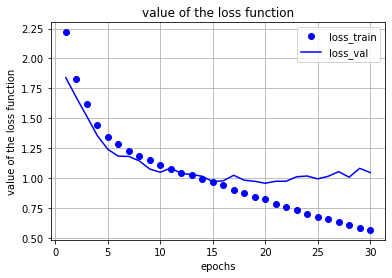

In [23]:
import matplotlib.pyplot as plt
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

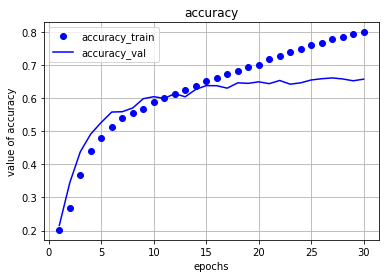

In [24]:
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

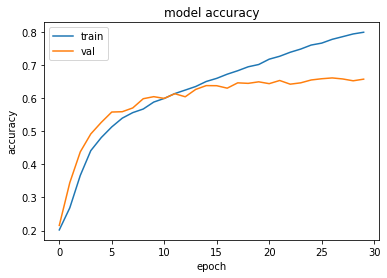

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

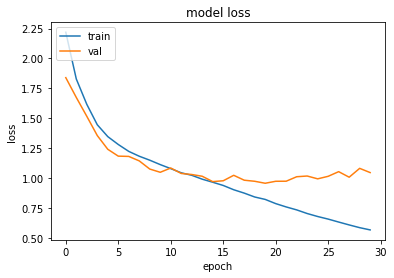

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
#saving the  model to be used later
fer_json = model.to_json()
with open("fer.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer.h5")
print("Saved model to disk")

Saved model to disk
